# Football Forecasting - WDSS Demo

Instert image here.

Here we provide a baseline model for our upcoming Premier League forecasting competition.

https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/   - Main Inspiration

https://en.wikipedia.org/wiki/Skellam_distribution   - Skellam Distribution Wiki

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skellam.html  - scipy.skellam

https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/    - Dixon Coles model

https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/computing/public/1718-ug-projects/Corentin-Herbinet-Using-Machine-Learning-techniques-to-predict-the-outcome-of-profressional-football-matches.pdf - ML Paper

https://www.youtube.com/watch?v=CF8arYimMbk&ab_channel=WarwickDataScienceSociety - Tim's Video (R)

In [1]:
# Import some modules
from scipy.stats import poisson, skellam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
# Fix Comments
from scipy.optimize import minimize
import seaborn as sns

# Importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### Poisson Distribution

In [10]:
# Have an avg incidence of 1.3 per event. Size is the number of event scales.
x_rvs = pd.Series(poisson.rvs(1.3, size=100000, random_state=2))
x_rvs.mean()

1.29415

In [11]:
data = x_rvs.value_counts().sort_index().to_dict()
data

{0: 27583, 1: 35414, 2: 22723, 3: 9948, 4: 3236, 5: 855, 6: 201, 7: 34, 8: 6}

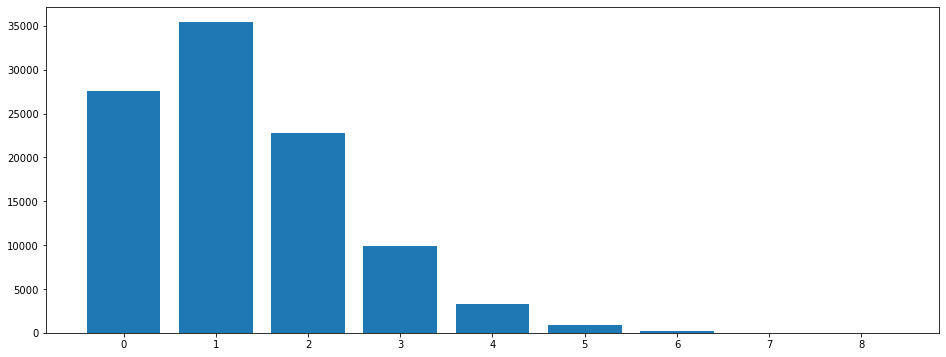

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(range(len(data)), list(data.values()))
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [16]:
def poisson_pmf(k, lam):
    return (lam ** k * np.exp(-lam)) / np.math.factorial(k)
poisson_pmf(0, 1.2)

0.30119421191220214

In [18]:
poisson.pmf(0, 1.2)

0.30119421191220214

In [20]:
poisson.std(1.2)

1.0954451150103321

In [88]:
season = 1819
name = {season: "epl_"+str(season)}
name[season] = 10

globals()["epl_"+str(season)] = 10
x = globals()["epl_"+str(season)]
print(x+2)

12


#### Trying Out David Sheehan

In [123]:
# Define a function to quickly get data from any given EPL season.
# Current GW fixtures are only added after the GW has finished.

def get_epl_data(season):
    """
    Takes in season formatted as YYYY (last 2 digits of Y1 and Y2 - no spaces or slashes)
    """
    
    x = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + str(season) + "/E0.csv")
    x = x[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
    x = x.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
    globals()["epl_"+str(season)] = x
    
    return globals()["epl_"+str(season)]

In [84]:
epl_1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv")
epl_1718.colum

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH',
       'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5',
       'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH',
       'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

#### Add link to column names descriptiions.

In [45]:
epl_1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv")
epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
epl_1718.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Arsenal,Leicester,4,3,H
1,Brighton,Man City,0,2,A
2,Chelsea,Burnley,2,3,A
3,Crystal Palace,Huddersfield,0,3,A
4,Everton,Stoke,1,0,H


In [50]:
epl_1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617 = epl_1617[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']]
epl_1617 = epl_1617.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
epl_1617.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Burnley,Swansea,0,1,A
1,Crystal Palace,West Brom,0,1,A
2,Everton,Tottenham,1,1,D
3,Hull,Leicester,2,1,H
4,Man City,Sunderland,2,1,H


### Poisson Distribution

#### $ P(x) = \frac{e^{-\lambda}\lambda^{x}}{x!}, \lambda > 0 $

In [46]:
epl_1617 = epl_1617[:-10]
epl_1617.mean()

HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

In [30]:
# probability of draw between home and away team
skellam.pmf(0.0,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.2480937681071708

In [31]:
# probability of home team winning by one goal
skellam.pmf(1,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.22706765807563964

In [33]:
goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [34]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

In [35]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Sat, 18 Sep 2021   Deviance:                       776.11
Time:                        21:03:32   Pearson chi2:                     659.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      

In [36]:
poisson_model.predict(pd.DataFrame(data={'team': 'Chelsea', 'opponent': 'Sunderland',
                                       'home':1},index=[1]))

1    3.061662
dtype: float64

In [37]:
poisson_model.predict(pd.DataFrame(data={'team': 'Sunderland', 'opponent': 'Chelsea',
                                       'home':0},index=[1]))

1    0.409373
dtype: float64

In [38]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=3)

array([[0.03108485, 0.01272529, 0.00260469, 0.00035543],
       [0.0951713 , 0.03896054, 0.00797469, 0.00108821],
       [0.14569118, 0.059642  , 0.01220791, 0.00166586],
       [0.14868571, 0.06086788, 0.01245883, 0.0017001 ]])

In [39]:
chel_sun = simulate_match(poisson_model, "Chelsea", "Sunderland", max_goals=10)
# chelsea win
np.sum(np.tril(chel_sun, -1))

0.8885986612364134

In [40]:
np.sum(np.diag(chel_sun))

0.08409349268649594

In [41]:
np.sum(np.triu(chel_sun, 1))

0.026961819942853054



Adapt final model function to output the ten matches in question with a specific input? Maybe have a dictionary and then convert?